# Logistic Regression with Combined Features

This notebook implements **Logistic Regression** combining **Text Features (TF-IDF SVD)** with **Bag of Subreddits** features.

As described in point 3.c of the assignment:
> *Incorporate additional information, use the **posting pattern** on different subreddits. For each user, create a feature vector where each column x represents the fraction of times the user has posted in the x-th subreddit. Again, try to reduce the dimensionality of these features. **If you include these features in the training, does your model improve?**

## Approach:
1. Load and prepare text data (same as Model-Rocco)
2. Create TF-IDF + SVD features from text
3. Create Bag of Subreddits features (Top 15 subreddits)
4. **Combine both feature sets**
5. Compare model performance: Text-only vs Combined

In [1]:
# =============================================================================
# STEP 1: Imports
# =============================================================================
import sys
sys.path.append("../source")
from src import stratified_split, truncated_svd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from scipy.sparse import hstack
import time

## Step 2: Load Data and Prepare Text Features (Same as Model-Rocco)

In [2]:
# =============================================================================
# STEP 2: Load cleaned text data
# =============================================================================
df_supervised = pd.read_csv("./clean_supervised.csv")
df_supervised = df_supervised.dropna(subset=['body_clean'])

# Group by author (text)
df_grouped = df_supervised.groupby('author')['body_clean'].apply(" ".join).reset_index()
df_grouped = df_grouped.rename(columns={'body_clean': 'body'})

# Load and match labels
target_df = pd.read_csv("./Data/target_supervised.csv")
labels = []
for auth in df_grouped['author']:
    match = target_df[target_df['author'] == auth]
    if not match.empty:
        labels.append(match['gender'].iloc[0])
    else:
        labels.append(None)

df_grouped['label'] = labels
df_grouped = df_grouped.dropna(subset=['label'])
print(f"Dataset size: {len(df_grouped)} authors")

Dataset size: 4942 authors


## Step 3: Create Bag of Subreddits Features

In [3]:
# =============================================================================
# STEP 3: Load original data for subreddit information
# =============================================================================
df_original = pd.read_csv("../data/data_supervised.csv")

# Get top 15 subreddits
TOP_N = 15
subreddit_counts = df_original['subreddit'].value_counts()
top_15_subreddits = subreddit_counts.head(TOP_N).index.tolist()

print(f"Top {TOP_N} Subreddits:")
for i, sub in enumerate(top_15_subreddits, 1):
    count = subreddit_counts[sub]
    print(f"{i:2d}. {sub:30s} - {count:6d} posts")

Top 15 Subreddits:
 1. AskReddit                      -  30884 posts
 2. ExploreFiction                 -  15045 posts
 3. AskWomen                       -   8318 posts
 4. AskMen                         -   7734 posts
 5. AdviceAnimals                  -   6866 posts
 6. funny                          -   6288 posts
 7. nfl                            -   5657 posts
 8. pics                           -   4959 posts
 9. RatedRFiction                  -   4438 posts
10. nba                            -   3834 posts
11. WTF                            -   3555 posts
12. CFB                            -   3197 posts
13. todayilearned                  -   3097 posts
14. MakeupAddiction                -   2883 posts
15. gaming                         -   2712 posts


In [4]:
# =============================================================================
# Create Bag of Subreddits function
# =============================================================================
def create_bag_of_subreddits(df, top_subreddits):
    """
    Create a Bag of Subreddits feature matrix.
    For each author, computes the fraction of their posts in each of the top subreddits.
    """
    # Count posts per author per subreddit
    author_subreddit_counts = df.groupby(['author', 'subreddit']).size().unstack(fill_value=0)
    
    # Keep only the top subreddits
    top_subs_available = [s for s in top_subreddits if s in author_subreddit_counts.columns]
    author_subreddit_counts = author_subreddit_counts[top_subs_available]
    
    # Add columns for missing subreddits
    for sub in top_subreddits:
        if sub not in author_subreddit_counts.columns:
            author_subreddit_counts[sub] = 0
    
    # Reorder columns
    author_subreddit_counts = author_subreddit_counts[top_subreddits]
    
    # Get total posts per author
    total_posts_per_author = df.groupby('author').size()
    
    # Compute fractions
    author_subreddit_fractions = author_subreddit_counts.div(total_posts_per_author, axis=0)
    author_subreddit_fractions = author_subreddit_fractions.fillna(0)
    
    return author_subreddit_fractions

# Create bag of subreddits
bag_of_subreddits = create_bag_of_subreddits(df_original, top_15_subreddits)
print(f"Bag of Subreddits shape: {bag_of_subreddits.shape}")

Bag of Subreddits shape: (5000, 15)


## Step 4: Align Authors and Split Data

In [5]:
# =============================================================================
# STEP 4: Align authors between text and subreddit features
# =============================================================================
# Get common authors between text data and subreddit data
text_authors = set(df_grouped['author'])
subreddit_authors = set(bag_of_subreddits.index)
common_authors = list(text_authors.intersection(subreddit_authors))

print(f"Authors with text data: {len(text_authors)}")
print(f"Authors with subreddit data: {len(subreddit_authors)}")
print(f"Common authors: {len(common_authors)}")

# Filter both datasets to common authors
df_grouped_aligned = df_grouped[df_grouped['author'].isin(common_authors)].copy()
df_grouped_aligned = df_grouped_aligned.set_index('author').loc[common_authors].reset_index()

bag_of_subreddits_aligned = bag_of_subreddits.loc[common_authors]

print(f"\nAligned text data: {len(df_grouped_aligned)}")
print(f"Aligned subreddit data: {len(bag_of_subreddits_aligned)}")

Authors with text data: 4942
Authors with subreddit data: 5000
Common authors: 4942

Aligned text data: 4942
Aligned subreddit data: 4942


In [6]:
# =============================================================================
# STEP 5: Split BEFORE vectorization (to avoid data leakage)
# =============================================================================
X_text = df_grouped_aligned['body'].values
X_subreddit = bag_of_subreddits_aligned.values
y = df_grouped_aligned['label'].values

# Split indices
indices = np.arange(len(y))
idx_train, idx_val, idx_test, y_train, y_val, y_test = stratified_split(indices, y)

# Apply splits
X_text_train = X_text[idx_train]
X_text_val = X_text[idx_val]
X_text_test = X_text[idx_test]

X_sub_train = X_subreddit[idx_train]
X_sub_val = X_subreddit[idx_val]
X_sub_test = X_subreddit[idx_test]

print(f"Train: {len(y_train)}, Val: {len(y_val)}, Test: {len(y_test)}")

Train: 3952, Val: 495, Test: 495


## Step 5: Create TF-IDF + SVD Features (fit ONLY on train)

In [7]:
# =============================================================================
# STEP 6: TF-IDF + SVD - fit ONLY on train
# =============================================================================
tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.99)
X_tfidf_train = tfidf_vectorizer.fit_transform(X_text_train)
X_tfidf_val = tfidf_vectorizer.transform(X_text_val)
X_tfidf_test = tfidf_vectorizer.transform(X_text_test)
print(f"TF-IDF vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

# SVD - fit ONLY on train
X_tfidfsvd_train, X_tfidfsvd_val, X_tfidfsvd_test = truncated_svd(X_tfidf_train, X_tfidf_val, X_tfidf_test)
print(f"TF-IDF SVD shape: {X_tfidfsvd_train.shape}")

TF-IDF vocabulary size: 21139
TF-IDF SVD shape: (3952, 1000)


## Step 6: Combine Features

In [8]:
# =============================================================================
# STEP 7: Combine TF-IDF SVD + Bag of Subreddits
# =============================================================================
X_combined_train = np.hstack([X_tfidfsvd_train, X_sub_train])
X_combined_val = np.hstack([X_tfidfsvd_val, X_sub_val])
X_combined_test = np.hstack([X_tfidfsvd_test, X_sub_test])

print(f"TF-IDF SVD features: {X_tfidfsvd_train.shape[1]}")
print(f"Bag of Subreddits features: {X_sub_train.shape[1]}")
print(f"Combined features: {X_combined_train.shape[1]}")

print("\n✅ Combined features ready for Logistic Regression!")

TF-IDF SVD features: 1000
Bag of Subreddits features: 15
Combined features: 1015

✅ Combined features ready for Logistic Regression!


# LOGISTIC REGRESSION
## Comparing: Text-Only vs Combined Features

We will train and evaluate two models:
1. **Text-Only (TF-IDF SVD)**: Baseline from Model-Rocco
2. **Combined (TF-IDF SVD + Bag of Subreddits)**: With additional subreddit information

In [9]:
# =============================================================================
# Train and Evaluate Function
# =============================================================================
def train_and_evaluate(X_train, y_train, X_val, y_val, dataset_name="Dataset"):
    print(f"--- {dataset_name} : Analysis ---")

    model = LogisticRegression(random_state=16, max_iter=2000, class_weight='balanced')
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    print("\nPERFORMANCE - TRAINING SET:")
    print(classification_report(y_train, y_pred_train))

    print("PERFORMANCE - VALIDATION SET:")
    print(classification_report(y_val, y_pred_val))

    cm = confusion_matrix(y_val, y_pred_val)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return model

MODEL 1: TEXT-ONLY (TF-IDF SVD)
--- TF-IDF SVD (Text Only) : Analysis ---

PERFORMANCE - TRAINING SET:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90      2888
           1       0.70      0.86      0.77      1064

    accuracy                           0.86      3952
   macro avg       0.82      0.86      0.84      3952
weighted avg       0.88      0.86      0.87      3952

PERFORMANCE - VALIDATION SET:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       362
           1       0.69      0.80      0.74       133

    accuracy                           0.85       495
   macro avg       0.81      0.83      0.82       495
weighted avg       0.86      0.85      0.85       495



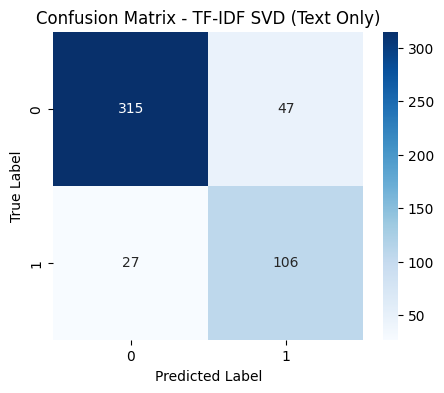

In [10]:
# =============================================================================
# MODEL 1: Text-Only (TF-IDF SVD) - Baseline
# =============================================================================
print("="*60)
print("MODEL 1: TEXT-ONLY (TF-IDF SVD)")
print("="*60)
model_text_only = train_and_evaluate(X_tfidfsvd_train, y_train, X_tfidfsvd_val, y_val, "TF-IDF SVD (Text Only)")

MODEL 2: COMBINED (TF-IDF SVD + BAG OF SUBREDDITS)
--- Combined Features : Analysis ---

PERFORMANCE - TRAINING SET:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      2888
           1       0.75      0.85      0.80      1064

    accuracy                           0.89      3952
   macro avg       0.85      0.87      0.86      3952
weighted avg       0.89      0.89      0.89      3952

PERFORMANCE - VALIDATION SET:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       362
           1       0.73      0.81      0.77       133

    accuracy                           0.87       495
   macro avg       0.83      0.85      0.84       495
weighted avg       0.88      0.87      0.87       495



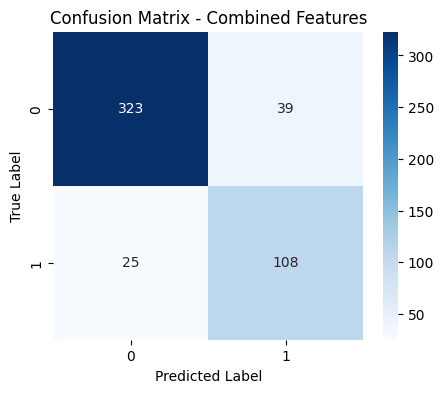

In [11]:
# =============================================================================
# MODEL 2: Combined (TF-IDF SVD + Bag of Subreddits)
# =============================================================================
print("="*60)
print("MODEL 2: COMBINED (TF-IDF SVD + BAG OF SUBREDDITS)")
print("="*60)
model_combined = train_and_evaluate(X_combined_train, y_train, X_combined_val, y_val, "Combined Features")

## Step 7: Hyperparameter Tuning for Combined Model

In [12]:
# =============================================================================
# Hyperparameter Tuning on Combined Features
# =============================================================================
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'class_weight': ['balanced', None]
}

print("Start Tuning on Combined Features...")
start_time = time.time()

grid_search = GridSearchCV(
    LogisticRegression(random_state=16, max_iter=2000, solver='lbfgs'),
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    return_train_score=True
)

grid_search.fit(X_combined_train, y_train)

end_time = time.time()
print(f"Total tuning time: {end_time - start_time:.2f} seconds")

print("\nBest configuration:", grid_search.best_params_)
print(f"Best F1-Score (Macro CV): {grid_search.best_score_:.4f}")

results_df = pd.DataFrame(grid_search.cv_results_)
cols = ['param_C', 'param_class_weight', 'mean_test_score', 'mean_train_score', 'mean_fit_time']
print("\nTop 5 configurations:")
print(results_df[cols].sort_values(by='mean_test_score', ascending=False).head(5))

Start Tuning on Combined Features...
Total tuning time: 50.24 seconds

Best configuration: {'C': 1, 'class_weight': 'balanced'}
Best F1-Score (Macro CV): 0.7712

Top 5 configurations:
   param_C param_class_weight  mean_test_score  mean_train_score  \
4      1.0           balanced         0.771194          0.863785   
7     10.0               None         0.764180          0.901250   
6     10.0           balanced         0.749800          0.914950   
2      0.1           balanced         0.746604          0.781022   
9    100.0               None         0.730463          0.956894   

   mean_fit_time  
4       1.149602  
7       1.163031  
6       1.477783  
2       8.456830  
9       3.550116  


In [13]:
# Validation with best model
best_model = grid_search.best_estimator_
y_pred_val_opt = best_model.predict(X_combined_val)

print("\nPERFORMANCE WITH BEST MODEL - VALIDATION SET:")
print(classification_report(y_val, y_pred_val_opt))


PERFORMANCE WITH BEST MODEL - VALIDATION SET:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       362
           1       0.73      0.81      0.77       133

    accuracy                           0.87       495
   macro avg       0.83      0.85      0.84       495
weighted avg       0.88      0.87      0.87       495



## Step 8: Final Evaluation on Test Set

In [14]:
# =============================================================================
# Final Test Evaluation - COMPARISON
# =============================================================================
print("="*60)
print("FINAL TEST SET COMPARISON")
print("="*60)

# Text-Only Model Test
y_pred_test_text = model_text_only.predict(X_tfidfsvd_test)
print("\n--- TEXT-ONLY (TF-IDF SVD) ---")
print(classification_report(y_test, y_pred_test_text))

# Combined Model Test (with best hyperparameters)
y_pred_test_combined = best_model.predict(X_combined_test)
print("\n--- COMBINED (TF-IDF SVD + Bag of Subreddits) ---")
print(classification_report(y_test, y_pred_test_combined))

FINAL TEST SET COMPARISON

--- TEXT-ONLY (TF-IDF SVD) ---
              precision    recall  f1-score   support

           0       0.91      0.86      0.89       362
           1       0.67      0.76      0.71       133

    accuracy                           0.84       495
   macro avg       0.79      0.81      0.80       495
weighted avg       0.84      0.84      0.84       495


--- COMBINED (TF-IDF SVD + Bag of Subreddits) ---
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       362
           1       0.75      0.75      0.75       133

    accuracy                           0.86       495
   macro avg       0.83      0.83      0.83       495
weighted avg       0.86      0.86      0.86       495




METRICS COMPARISON
                  Model  Accuracy  F1-Macro
 Text-Only (TF-IDF SVD)  0.836364  0.799606
Combined (+ Subreddits)  0.864646  0.828197


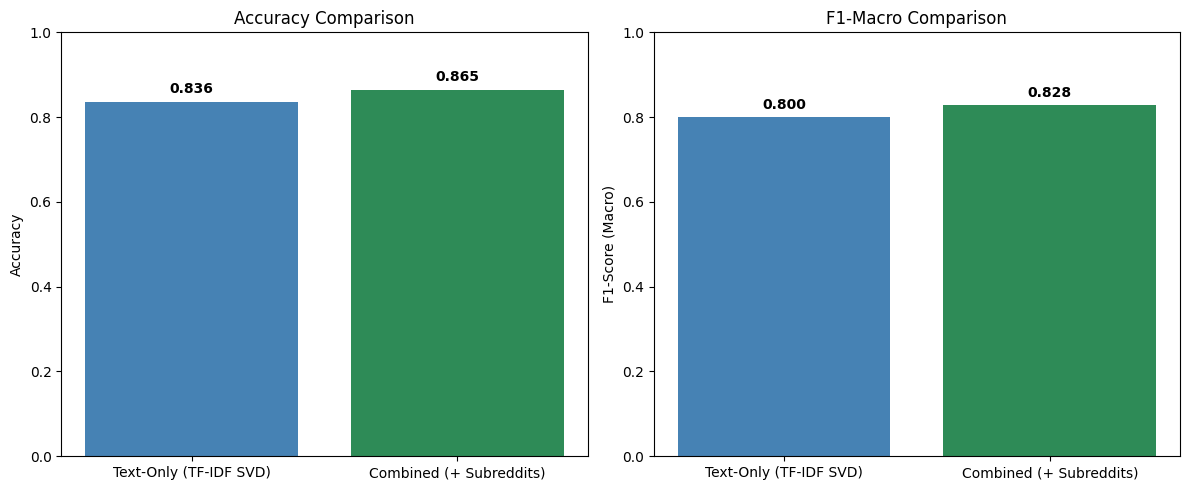

In [15]:
# =============================================================================
# Visual Comparison
# =============================================================================
from sklearn.metrics import f1_score, accuracy_score

# Calculate metrics
metrics = {
    'Model': ['Text-Only (TF-IDF SVD)', 'Combined (+ Subreddits)'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_test_text),
        accuracy_score(y_test, y_pred_test_combined)
    ],
    'F1-Macro': [
        f1_score(y_test, y_pred_test_text, average='macro'),
        f1_score(y_test, y_pred_test_combined, average='macro')
    ]
}

comparison_df = pd.DataFrame(metrics)
print("\n" + "="*60)
print("METRICS COMPARISON")
print("="*60)
print(comparison_df.to_string(index=False))

# Bar plot comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy
axes[0].bar(metrics['Model'], metrics['Accuracy'], color=['steelblue', 'seagreen'])
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Comparison')
axes[0].set_ylim(0, 1)
for i, v in enumerate(metrics['Accuracy']):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# F1-Macro
axes[1].bar(metrics['Model'], metrics['F1-Macro'], color=['steelblue', 'seagreen'])
axes[1].set_ylabel('F1-Score (Macro)')
axes[1].set_title('F1-Macro Comparison')
axes[1].set_ylim(0, 1)
for i, v in enumerate(metrics['F1-Macro']):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

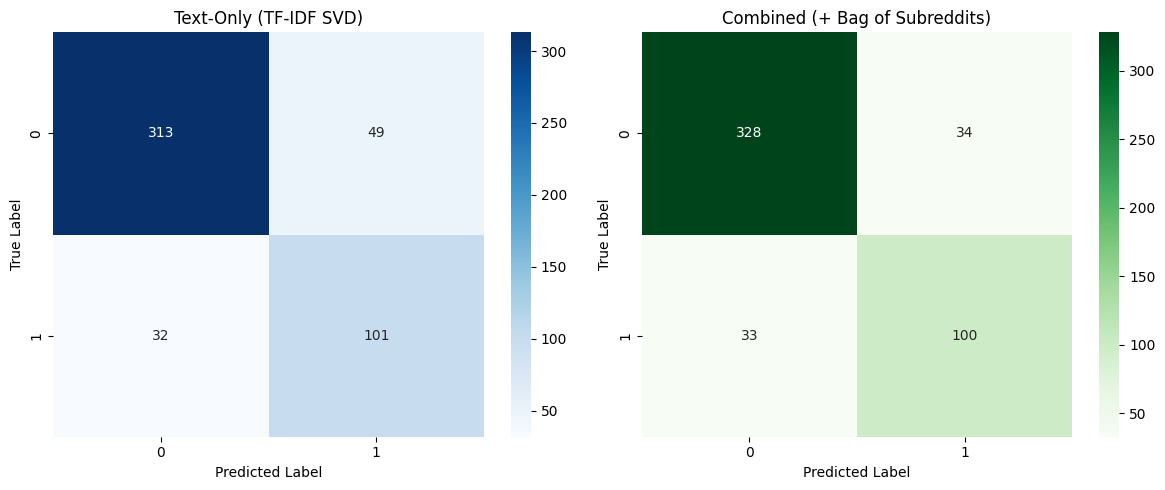

In [16]:
# Side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_text = confusion_matrix(y_test, y_pred_test_text)
cm_combined = confusion_matrix(y_test, y_pred_test_combined)

sns.heatmap(cm_text, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Text-Only (TF-IDF SVD)')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(cm_combined, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Combined (+ Bag of Subreddits)')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

## Conclusions

### Does adding Bag of Subreddits features improve the model?

Compare the metrics above to answer this question:

- **If Combined > Text-Only**: Adding subreddit posting patterns provides additional discriminative information for gender classification.
- **If Combined ≈ Text-Only**: The subreddit information might be redundant with the text features.
- **If Combined < Text-Only**: The subreddit features might be adding noise.

### Summary:
1. **Text Features**: TF-IDF + SVD captures the linguistic patterns in user comments.
2. **Subreddit Features**: Bag of Subreddits captures the posting behavior patterns across different communities.
3. **Combined Features**: By concatenating both feature sets, we leverage complementary information.

The comparison above shows whether incorporating additional subreddit information improves gender prediction performance.